#Convolutional Neural Networks, Filters and Pooling Examples

Integrated code examples along with the CNN lecture

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
No GPU was detected. CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


A couple utility functions to plot grayscale and RGB images:

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# What is a Convolution?

images batch size, height, width and channels (R,G,B) before processing: (2, 427, 640, 3)
original image


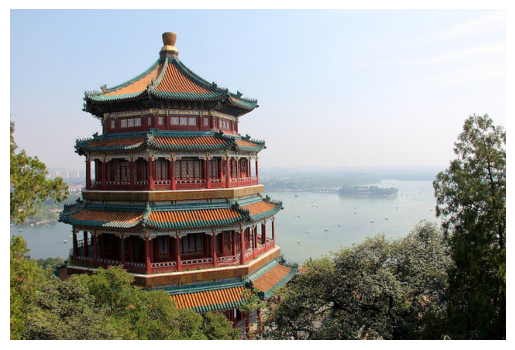

images [0 or 1], height, width and filters[0 or 1] after kernel processing: (2, 427, 640, 2)


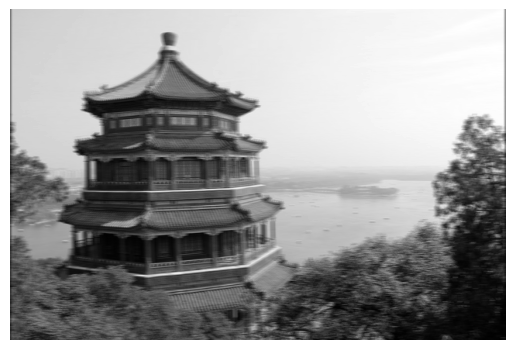

In [ ]:
import numpy as np
# china cottage and flower are contained in sklearn's package
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255

images = np.array([china, flower])
# Peer into the specifics of the images variable
print('images batch size, height, width and channels (R,G,B) before processing:',
      images.shape)
batch_size, height, width, channels = images.shape
print('original image')
plt.imshow(images[0], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

# Create 2 filters
# The book uses a 7 x 7 kernel
# KEY POINT! -- for the filters input
#
# filters: A Tensor. Must have the same type as input.
#          A 4-D tensor of shape [filter_height, filter_width, in_channels, out_channels]
#
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
print('images [0 or 1], height, width and filters[0 or 1] after kernel processing:',
      outputs.shape)

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

In [ ]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


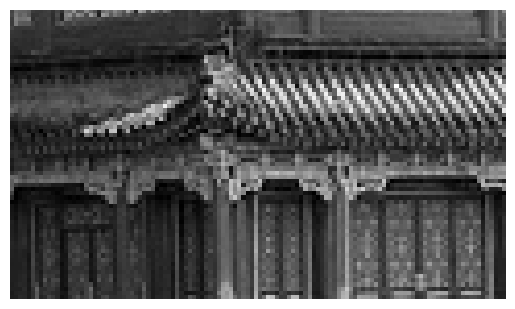

Saving figure china_vertical


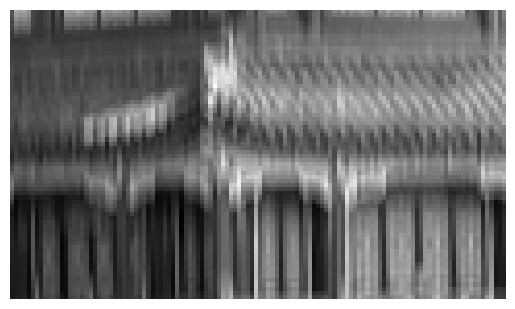

Saving figure china_horizontal


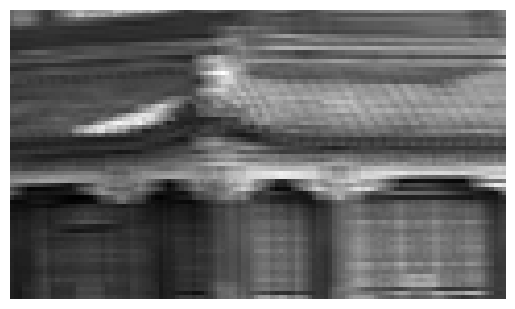

In [ ]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

The filters shape is as follows:  (7, 7, 3, 2)

Explore the vertical filter
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


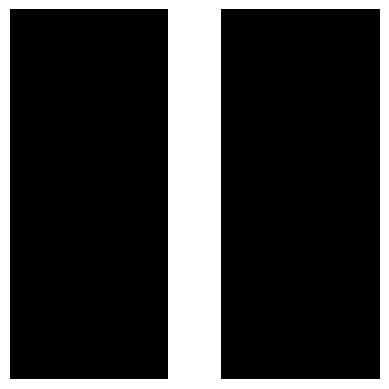

Explore the horizontal filter
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


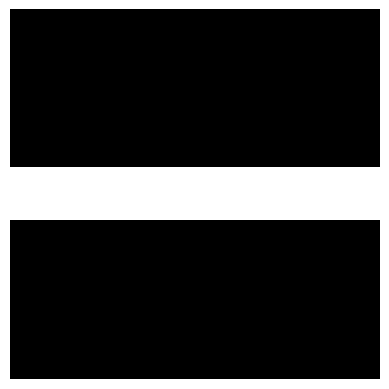

In [ ]:
# print filters shape
print('The filters shape is as follows: ',filters.shape)
# printing vertical filter, added for clarity
print()
print("Explore the vertical filter")
print(filters[:, :, 0, 0])
plot_image(filters[:, :, 0, 0])
plt.show()

# printing the horizontal filter, added for clarity
print("Explore the horizontal filter")
print(filters[:, :, 0, 1])
plot_image(filters[:, :, 0, 1])
plt.show()

### Add -- Cat and Dog

max pixel value:  1.0
catdog image height, width and channels (R,G,B) before processing: (1080, 1230, 3)
original catdog image


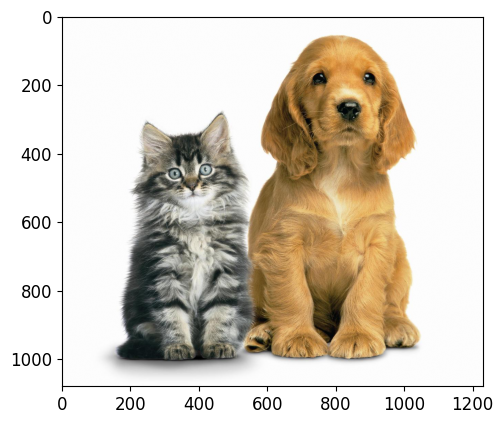

In [33]:
# Cat and dog photo downloaded from the following site
# http://www.mendhamtownship.org/cn/webpage.cfm?TID=77&TPID=10817
# Mendham Township - Animal Control And Licensing
# Uses maatplotlib.pyplot as plt -- declared in previous block
catdog = plt.imread('drive/MyDrive/Colab Notebooks/OPER 785 08 Cat_Dog_2.jpg') /  255
catdog_image = np.array([catdog])

print('max pixel value: ', catdog_image.max())

# Peer into the specifics of the images variable
print('catdog image height, width and channels (R,G,B) before processing:',
      catdog.shape)
height, width, channels = catdog.shape

print('original catdog image')
plt.imshow(catdog) # plot the original image
plt.axis("on")
plt.show()

image (there is only one), height, width and filters[0 or 1] after kernel processing: (1, 1080, 1230, 2)


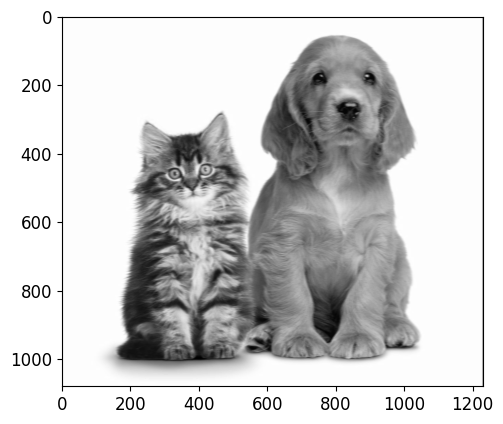

In [34]:
# using the filters defined above, now apply them to the cat and dog

cdoutputs = tf.nn.conv2d(catdog_image, filters, strides=1, padding="SAME")
print('image (there is only one), height, width and filters[0 or 1] after kernel processing:',
      cdoutputs.shape)

plt.imshow(cdoutputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("on") # Not shown in the book
plt.show()

Saving figure catdog_original


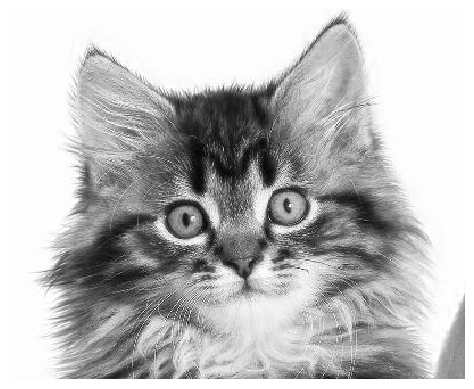

Saving figure catdog_vertical


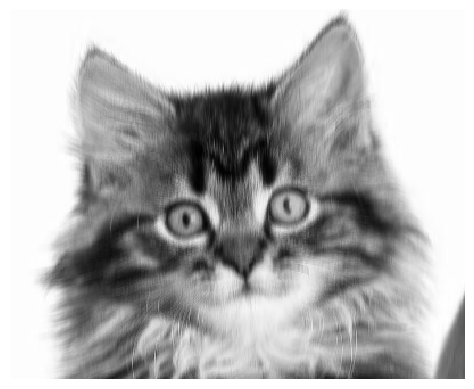

Saving figure catdog_horizontal


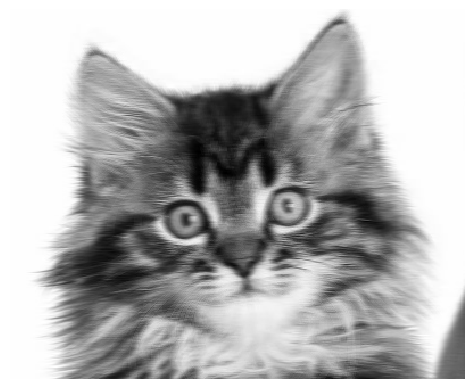

In [35]:
plot_image(catdog_image[0, 275:600, 175:575, 0])
save_fig("catdog_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["catdog_vertical", "catdog_horizontal"]):
    plot_image(cdoutputs[0, 275:600, 175:575, feature_map_index])
    save_fig(filename, tight_layout=False)
    plt.show()

image (there is only 1), height, width and filters[0 or 1] after kernel processing: (1, 1080, 1230, 1)


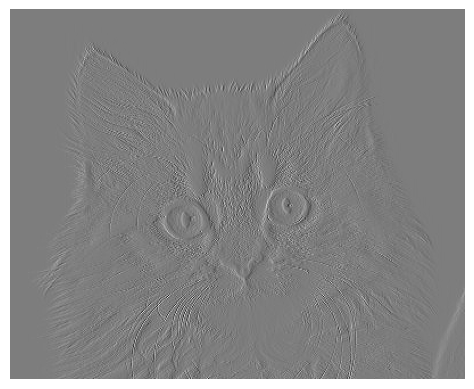

In [36]:
# Implment an edge using a simple
filters = np.zeros(shape=(1, 2, channels, 1), dtype=np.float32)

# here's the simple edge filter
filters[:,:,1,0] = [[1, -1]]

cdoutputs = tf.nn.conv2d(catdog_image, filters, strides=1, padding="SAME")
print('image (there is only 1), height, width and filters[0 or 1] after kernel processing:',
      cdoutputs.shape)

plt.imshow(cdoutputs[0, 275:600, 175:575, 0], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

average of pixels touching center pixel
image (there is only 1), height, width and filters(only one) after kernel processing (stride=1): (1, 1080, 1230, 1)


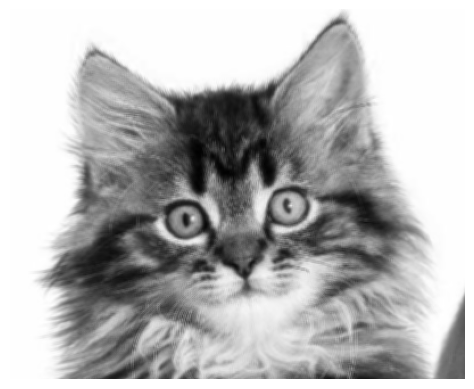

inverse delta function -- for lack of better works 
image (there is only 1), height, width and filters(only one) after kernel processing (stride=1): (1, 1080, 1230, 1)


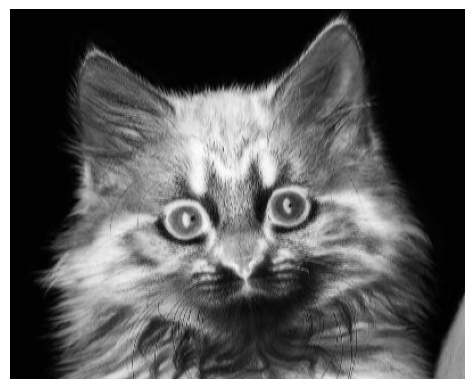

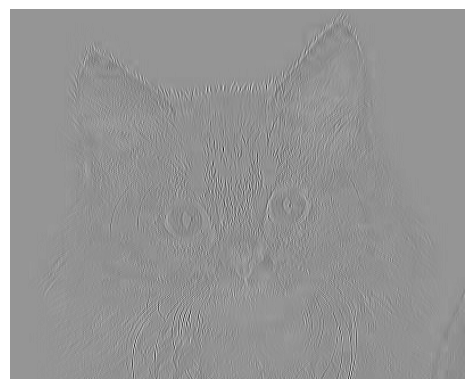

In [37]:
# Let's apply two filters to the cat dog image
# The example below will take the average of all adjacent points for a given pixel
# This will be performed in two steps:
# filter_image_1 - average of all the pixels touching a given pixel (i.e., the one in the middle)
# filter_image_2 - a delta filter of the given image

filter_image_1 = np.zeros(shape=(3, 3, channels, 1), dtype=np.float32)
filter_image_2 = np.zeros(shape=(3, 3, channels, 1), dtype=np.float32)

# filter_1 - average of all the pixels touching a given pixel
filter_1in = (1/8) * np.array([[1,1,1],[1,0,1],[1,1,1]])

# filter_2 - inverse delta filter
filter_2in = np.array([[0,0,0],[0,-1,0],[0,0,0]])

filter_image_1[:, :, :, 0] = filter_1in
filter_image_2[:, :, :, 0] = filter_2in

# output result of filter_image_1 kernel
out_image1 = tf.nn.conv2d(catdog_image, filter_image_1, strides=1, padding="SAME")
print('average of pixels touching center pixel')
print('image (there is only 1), height, width and filters(only one) after kernel processing (stride=1):',
      out_image1.shape)

plt.imshow(out_image1[0, 275:600, 175:575, 0],cmap="gray") # plot image's 1st feature map
plt.axis("off") # Not shown in the book
plt.show()

# output result of filter_image_2 kernel
out_image2 = tf.nn.conv2d(catdog_image, filter_image_2, strides=1, padding="SAME")
print('inverse delta function -- for lack of better works ')
print('image (there is only 1), height, width and filters(only one) after kernel processing (stride=1):',
      out_image1.shape)

plt.imshow(out_image2[0, 275:600, 175:575, 0],cmap="gray") # plot image's 1st feature map
plt.axis("off") # Not shown in the book
plt.show()

# add the two images and show the result
out_image_DeltaMinusAvg = out_image2 + out_image1

plt.imshow(out_image_DeltaMinusAvg[0, 275:600, 175:575, 0],cmap="gray") # plot image's 1st feature map
plt.axis("off") # Not shown in the book
plt.show()



image (there is only 1), height, width and filters(only one) after kernel processing (stride=1): (1, 1080, 1230, 1)


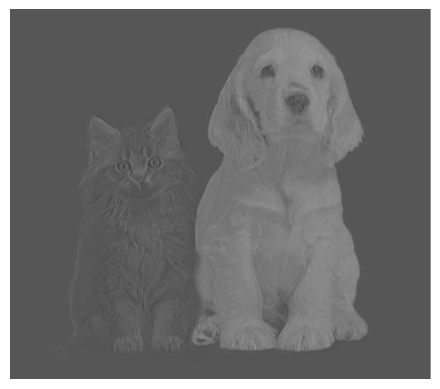

image (there is only 1), height, width and filters(only one) after kernel processing (stride=2): (1, 540, 615, 1)


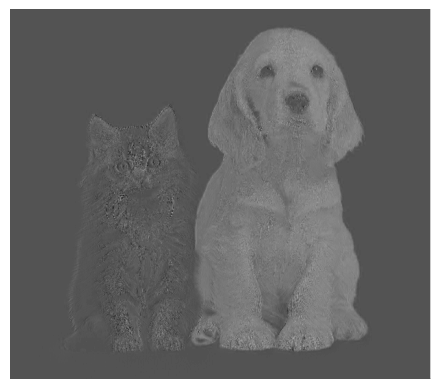

image (there is only 1), height, width and filters(only one) after kernel processing (stride=3): (1, 360, 410, 1)


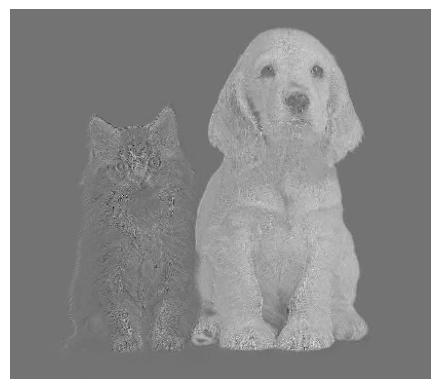

image (there is only 1), height, width and filters(only one) after kernel processing (stride=4): (1, 270, 308, 1)


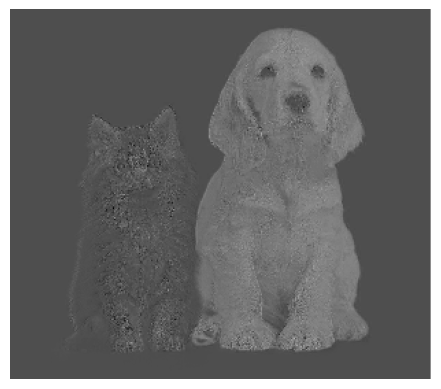

image (there is only 1), height, width and filters(only one) after kernel processing (stride=5): (1, 216, 246, 1)


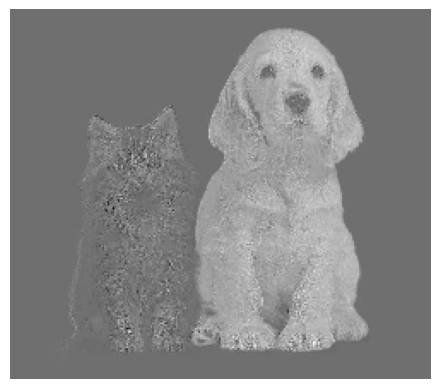

image (there is only 1), height, width and filters(only one) after kernel processing (stride=6): (1, 180, 205, 1)


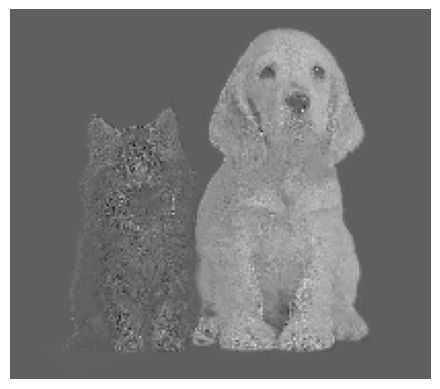

In [38]:
# Let's vary the strides ... what happens?
# Since we're on a roll, let's stay with the cat dog image
# Create 1 filter ...
filters = np.zeros(shape=(3, 3, channels, 1), dtype=np.float32)

# edge detection, shift and subtract
sns_filter = np.array([[0,0,0],[0,1,0],[0,0,-1]])
filters[:, :, :, 0] = sns_filter

outputs = tf.nn.conv2d(catdog_image, filters, strides=1, padding="SAME")
print('image (there is only 1), height, width and filters(only one) after kernel processing (stride=1):',
      outputs.shape)

plt.imshow(outputs[0, :, :, 0],cmap="gray") # plot image's 1st feature map
plt.axis("off") # Not shown in the book
plt.show()

outputs = tf.nn.conv2d(catdog_image, filters, strides=2, padding="SAME")
print('image (there is only 1), height, width and filters(only one) after kernel processing (stride=2):',
      outputs.shape)

plt.imshow(outputs[0, :, :, 0],cmap="gray") # plot image's 1st feature map
plt.axis("off") # Not shown in the book
plt.show()

outputs = tf.nn.conv2d(catdog_image, filters, strides=3, padding="SAME")
print('image (there is only 1), height, width and filters(only one) after kernel processing (stride=3):',
      outputs.shape)

plt.imshow(outputs[0, :, :, 0],cmap="gray") # plot image's 1st feature map
plt.axis("off") # Not shown in the book
plt.show()

outputs = tf.nn.conv2d(catdog_image, filters, strides=4, padding="SAME")
print('image (there is only 1), height, width and filters(only one) after kernel processing (stride=4):',
      outputs.shape)

plt.imshow(outputs[0, :, :, 0],cmap="gray") # plot image's 1st feature map
plt.axis("off") # Not shown in the book
plt.show()

outputs = tf.nn.conv2d(catdog_image, filters, strides=5, padding="SAME")
print('image (there is only 1), height, width and filters(only one) after kernel processing (stride=5):',
      outputs.shape)

plt.imshow(outputs[0, :, :, 0],cmap="gray") # plot image's 1st feature map
plt.axis("off") # Not shown in the book
plt.show()

outputs = tf.nn.conv2d(catdog_image, filters, strides=6, padding="SAME")
print('image (there is only 1), height, width and filters(only one) after kernel processing (stride=6):',
      outputs.shape)

plt.imshow(outputs[0, :, :, 0],cmap="gray") # plot image's 1st feature map
plt.axis("off") # Not shown in the book
plt.show()



image (there is only 1), height, width and filters[0 or 1] after kernel processing: (1, 1080, 1230, 2)


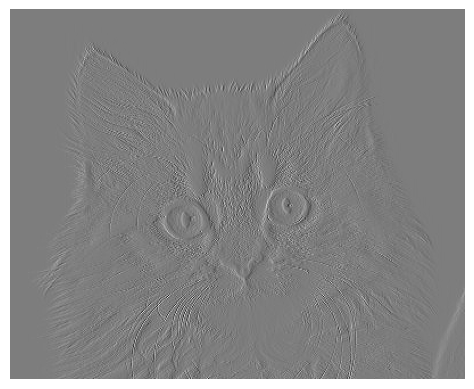

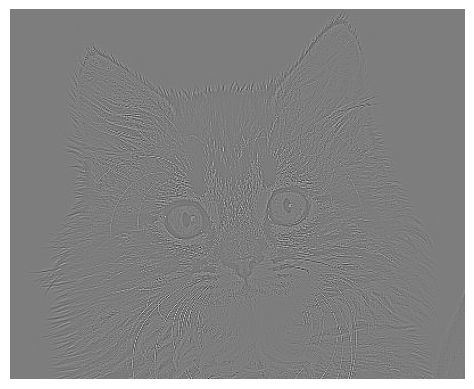

In [39]:
# Last edge filter example
# Create 2 edge filters, each 3 x 3
filters = np.zeros(shape=(3, 3, channels, 2), dtype=np.float32)
filters[:, :, 1, 0] = [[0,0,0],[0,1,-1],[0,0,0]]

# 2nd edge filter, just some finer detail
edge_filter2 = (1/8) * np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
filters[:, :, 1, 1] = edge_filter2

outputs = tf.nn.conv2d(catdog_image, filters, strides=1, padding="SAME")
print('image (there is only 1), height, width and filters[0 or 1] after kernel processing:',
      outputs.shape)

plt.imshow(outputs[0, 275:600, 175:575, 0], cmap="gray") # plot image's 1st feature map
plt.axis("off") # Not shown in the book
plt.show()

plt.imshow(outputs[0, 275:600, 175:575, 1], cmap="gray") # plot image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

# Pooling layer

## Max pooling

In [40]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [41]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

original image size:  (70, 120, 3)
pooled image size:  (35, 60, 3)
Saving figure china_max_pooling


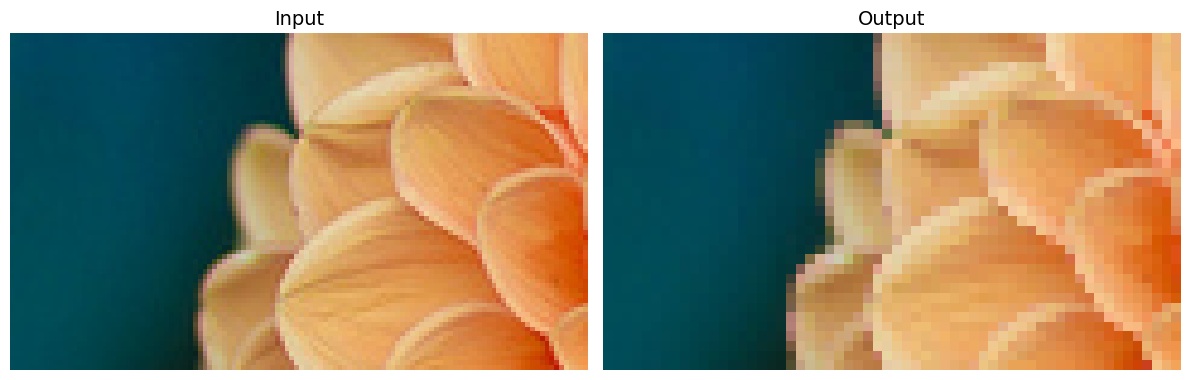

In [42]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[1])  # plot the 1st image
ax1.axis("off")

print('original image size: ', cropped_images[1].shape)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[1])  # plot the output for the 1st image
ax2.axis("off")
print('pooled image size: ', output[1].shape)
save_fig("china_max_pooling")
plt.show()

## Depth-wise pooling

In [43]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [44]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

Or just use a `Lambda` layer:

In [45]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

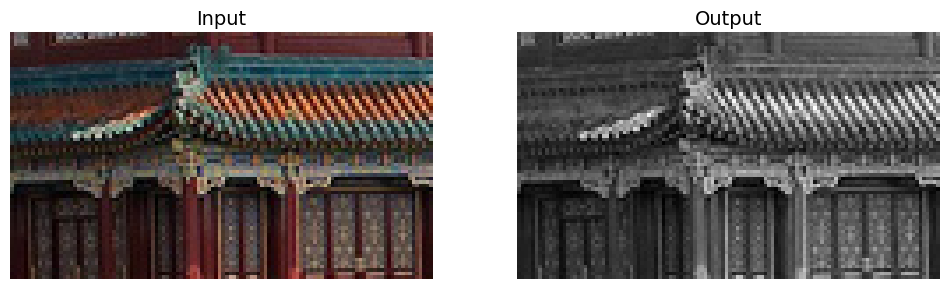

In [46]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## Average pooling

In [47]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [48]:
output_avg = avg_pool(cropped_images)

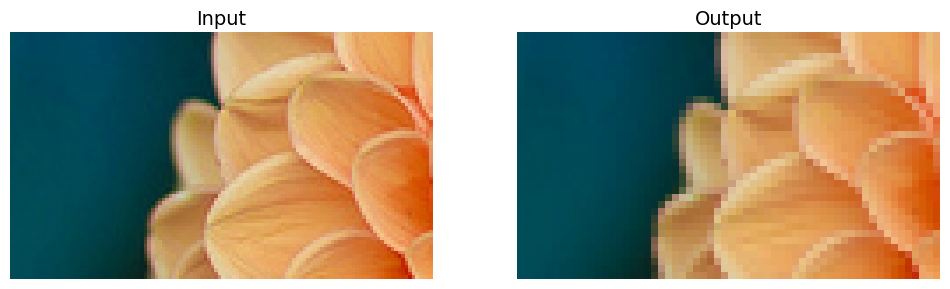

In [49]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[1])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[1])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Global Average Pooling

In [50]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [51]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>